# T-SNE on Amazon Food Reviews Using Bag of Words(BoW) Technique

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1. index
2. Id
3. ProductId - unique identifier for the product
4. UserId - unqiue identifier for the user
5. ProfileName
6. HelpfulnessNumerator - number of users who found the review helpful
7. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8. Score - rating between 1 and 5
9. Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, convert all the reviews into a vector using four techniques: BoW; tf_idf; Avg_w2v and tf_idf_w2v and then plot T-SNE for each technique. Separate all positive and negative reviews by blue and red colors respectively.**

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

### Loading the data

The dataset is available in two forms

1) .csv file

2) SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. 
Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import nltk             #nltk = natural language tool kit
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud

In [2]:
connection = sqlite3.connect('FinalAmazonFoodReviewsDataset.sqlite')

In [3]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [4]:
data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [5]:
data.shape

(364171, 12)

In [6]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [7]:
allPositiveReviews = pd.read_sql_query("SELECT * FROM Reviews WHERE Score = 'Positive'", connection)

In [8]:
allPositiveReviews.shape

(307061, 12)

In [9]:
allNegativeReviews = pd.read_sql_query("SELECT * FROM Reviews WHERE Score = 'Negative'", connection)

In [10]:
allNegativeReviews.shape

(57110, 12)

In [11]:
positiveReviews_5000 = allPositiveReviews[:5000]

In [12]:
print(positiveReviews_5000.shape)


(5000, 12)


In [13]:
positiveReviews_5000.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
2,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
3,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...
4,6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,Positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,this saltwat taffi had great flavor and was ve...


In [14]:
negativeReviews_5000 = allNegativeReviews[:5000]

In [15]:
print(negativeReviews_5000.shape)

(5000, 12)


In [16]:
negativeReviews_5000.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
1,12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,Negative,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,cat have been happili eat felida platinum for ...
2,16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,Negative,1348099200,poor taste,I love eating them and they are good for watch...,love eat them and they are good for watch and ...
3,26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,Negative,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",the candi just red flavor just plan and chewi ...
4,47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,Negative,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",this oatmeal not good it mushi soft dont like ...


In [17]:
frames_10000 = [positiveReviews_5000, negativeReviews_5000]

In [18]:
FinalPositiveNegative = pd.concat(frames_10000)

In [19]:
FinalPositiveNegative.shape

(10000, 12)

In [20]:
# Sorting dataframe by 'Time'
FinalSortedPositiveNegative_10000 = FinalPositiveNegative.sort_values('Time', axis=0, ascending=True, inplace=False)

In [21]:
FinalSortedPositiveNegativeScore_10000 = FinalSortedPositiveNegative_10000["Score"]

In [22]:
print(FinalSortedPositiveNegative_10000.shape)
print(FinalSortedPositiveNegativeScore_10000.shape)

(10000, 12)
(10000,)


In [23]:
FinalSortedPositiveNegative_10000.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
649,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,Positive,961718400,Great Product,This was a really good idea and the final prod...,this was realli good idea and the final produc...
648,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,Positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,just receiv shipment and could hard wait tri t...
4923,7427,8111,B0000EIE2Z,A3M174IC0VXOS2,Gail Cooke,3,3,Positive,1075420800,BEST BLUEBERRIES,In the winter when fresh blueberries exceed ou...,the winter when fresh blueberri exceed our foo...
2030,3481,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,Positive,1081555200,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,mae ploy sweet chili sauc becom standard condi...
4388,6790,7432,B0001E1IME,A2IKCTD1I73PLW,Adeba,2,8,Positive,1083456000,amazon monopoly/ripoff,love the snack. wanted to buy a bunch.<p>ship...,love the snack want buy bunch ship amazon more...


## Bag of Words(BoW)

In [24]:
positive_reviews = FinalSortedPositiveNegative_10000[(FinalSortedPositiveNegative_10000["Score"] == "Positive")]
negative_reviews = FinalSortedPositiveNegative_10000[(FinalSortedPositiveNegative_10000["Score"] == "Negative")]

In [25]:
positive_reviews.shape, negative_reviews.shape

((5000, 12), (5000, 12))

In [26]:
positive_bow_vect =  CountVectorizer(stop_words = "english")
positive_bow = positive_bow_vect.fit_transform(positive_reviews["ProcessedText"].values)

In [27]:
positive_bow.shape

(5000, 8690)

In [28]:
features_positive = positive_bow_vect.get_feature_names()
len(features_positive), type(features_positive)

(8690, list)

In [29]:
count = []
for i in range(len(features_positive)):
    total = positive_bow.getcol(i).sum() # it will give sum of all the values in 'i'th column 
    count.append(total)

In [30]:
positive_dict = dict(zip(features_positive, count))

In [31]:
sortedDict_Positive = sorted(positive_dict.items(), key = lambda positive_dict: positive_dict[1], reverse = True)

In [32]:
for i in range(200):
    print(sortedDict_Positive[i])

('like', 2171)
('tast', 2010)
('good', 1874)
('flavor', 1852)
('great', 1781)
('use', 1738)
('love', 1662)
('product', 1506)
('veri', 1482)
('coffe', 1403)
('just', 1399)
('tri', 1374)
('make', 1294)
('tea', 1040)
('buy', 870)
('realli', 866)
('time', 846)
('onli', 838)
('food', 819)
('mix', 797)
('price', 792)
('littl', 761)
('eat', 750)
('best', 748)
('drink', 746)
('order', 737)
('dont', 736)
('bag', 710)
('amazon', 683)
('store', 667)
('becaus', 640)
('better', 637)
('ive', 581)
('recommend', 578)
('sugar', 576)
('cup', 563)
('ani', 546)
('chip', 539)
('high', 511)
('year', 509)
('pack', 496)
('want', 494)
('work', 492)
('sweet', 481)
('snack', 478)
('look', 471)
('water', 468)
('brand', 467)
('delici', 462)
('milk', 447)
('day', 443)
('purchas', 440)
('box', 439)
('nice', 439)
('favorit', 432)
('chocol', 429)
('enjoy', 424)
('free', 422)
('perfect', 407)
('packag', 399)
('say', 398)
('thing', 398)
('easi', 395)
('mani', 394)
('bought', 393)
('fresh', 392)
('add', 388)
('differ', 3

In [39]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

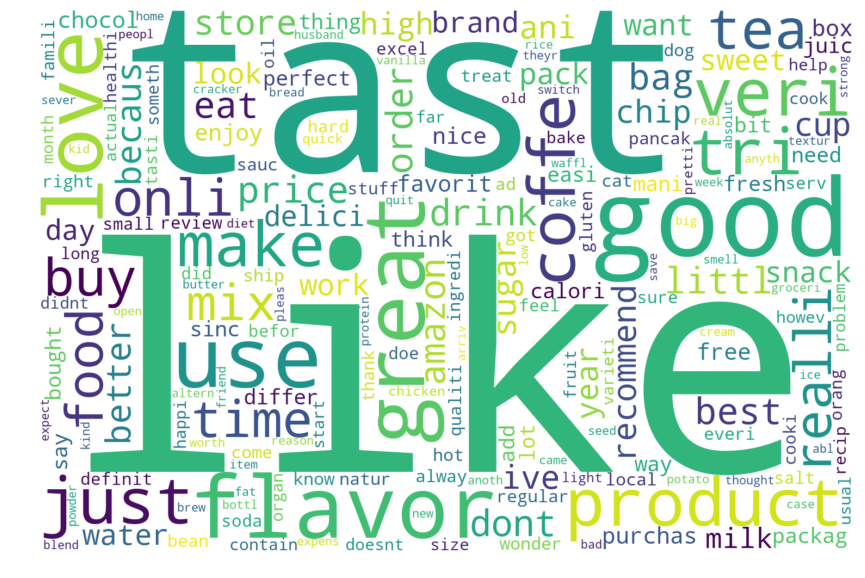

In [40]:
PlotWordCloud(positive_dict)

**This is a Word Cloud for all the positive reviews in the corpus.**<br>
**This Word Cloud plot correponds to the most frequent words in all positive reviews.**

How I have plotted this word cloud.
Now BoW representation is based on the count of the word in a document. If a word Wi occurs in many document then the sum of its column will be high. Therefore, I have just calculated the sum of all the column and created the dictionary where keys are the features and values are the sum of that column. I feeded this dictionary to the wordcloud and plotted the same.
the same procedure is followed for negative reviews as well

In [67]:
negative_bow_vect =  CountVectorizer(stop_words = "english")
negative_bow = negative_bow_vect.fit_transform(negative_reviews["ProcessedText"].values)

In [68]:
negative_bow.shape

(5000, 9648)

In [69]:
features_negative = negative_bow_vect.get_feature_names()
len(features_negative), type(features_negative)

(9648, list)

In [70]:
count = []
for i in range(len(features_negative)):
    total = negative_bow.getcol(i).sum() # it will give sum of all the values in 'i'th column 
    count.append(total)

In [71]:
negative_dict = dict(zip(features_negative, count))

In [73]:
sortedDict_Negative = sorted(negative_dict.items(), key = lambda negative_dict: negative_dict[1], reverse = True)

In [74]:
for i in range(200):
    print(sortedDict_Negative[i])

('tast', 3153)
('like', 2911)
('product', 2408)
('just', 1775)
('tri', 1662)
('flavor', 1656)
('veri', 1597)
('use', 1407)
('good', 1345)
('coffe', 1198)
('tea', 1147)
('buy', 1135)
('food', 1106)
('dog', 1040)
('dont', 1038)
('order', 1020)
('becaus', 979)
('make', 940)
('time', 919)
('drink', 918)
('box', 915)
('onli', 897)
('realli', 885)
('eat', 869)
('bag', 851)
('look', 836)
('amazon', 821)
('packag', 802)
('love', 769)
('review', 712)
('bought', 707)
('purchas', 704)
('better', 691)
('chocol', 691)
('ani', 689)
('did', 675)
('water', 666)
('bad', 665)
('disappoint', 661)
('think', 643)
('want', 634)
('sugar', 630)
('say', 624)
('mix', 619)
('know', 616)
('price', 608)
('didnt', 604)
('ingredi', 566)
('smell', 560)
('ive', 557)
('cup', 553)
('thought', 549)
('great', 548)
('littl', 544)
('way', 542)
('got', 523)
('brand', 515)
('thing', 510)
('store', 502)
('someth', 496)
('open', 491)
('receiv', 484)
('item', 483)
('treat', 480)
('differ', 472)
('sweet', 465)
('ginger', 464)
('m

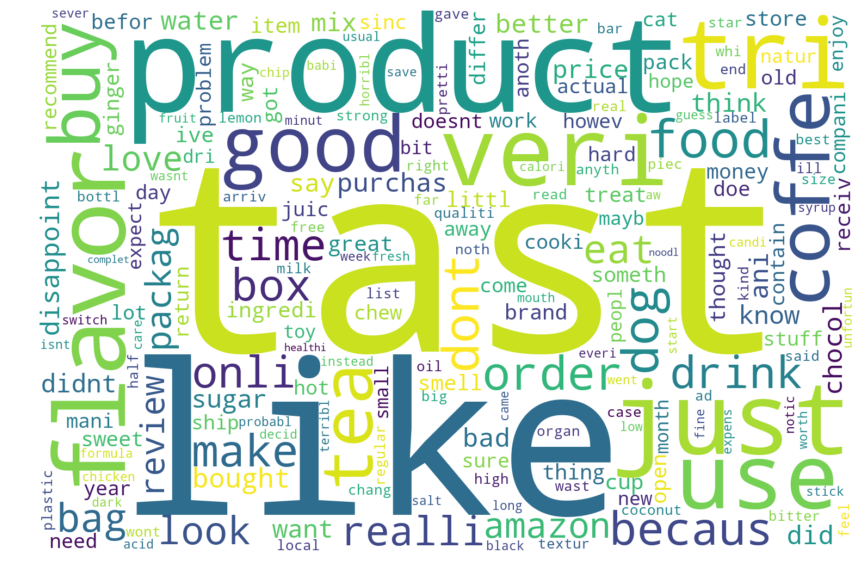

In [75]:
PlotWordCloud(negative_dict)

**This is a Word Cloud for all the negative reviews in the corpus.**<br>
**This Word Cloud plot correponds to the most frequent words in all negative reviews.**

In [31]:
count_vect = CountVectorizer(stop_words = "english")

In [32]:
BoW = count_vect.fit_transform(FinalSortedPositiveNegative_10000['ProcessedText'].values)

In [33]:
type(BoW)

scipy.sparse.csr.csr_matrix

In [34]:
BoW.get_shape()

(10000, 12839)

It means that there are 10000 reviews means there are 10000 rows and there are total 12839 unique words in all the reviews.

In [35]:
#Standardizing our data matrix
from sklearn.preprocessing import StandardScaler
standardized_data_BoW = StandardScaler(with_mean = False).fit_transform(BoW)
print(standardized_data_BoW.shape)
print(type(standardized_data_BoW))

(10000, 12839)
<class 'scipy.sparse.csr.csr_matrix'>


C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [36]:
# converting sparse matrix to dense matrix for TSNE
BoW_dense = standardized_data_BoW.todense()

In [37]:
print(type(BoW_dense))

<class 'numpy.matrixlib.defmatrix.matrix'>


## T-SNE of BoW

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=100, n_iter=2500)

tsne_data = model.fit_transform(BoW_dense)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, FinalSortedPositiveNegativeScore_10000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

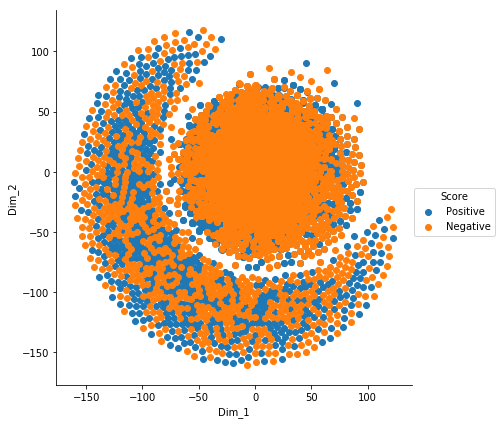

In [98]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plot.scatter, 'Dim_1', 'Dim_2').add_legend()
plot.show()

In [38]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, perplexity=5000, n_iter=2500)

tsne_data = model.fit_transform(BoW_dense)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, FinalSortedPositiveNegativeScore_10000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

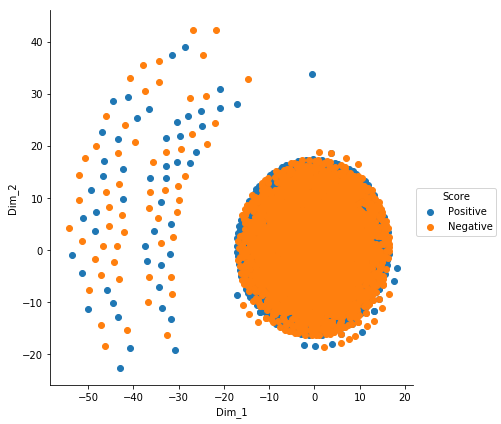

In [39]:
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plot.scatter, 'Dim_1', 'Dim_2').add_legend()
plot.show()